# Project Description

In response to the COVID-19 pandemic, a lot of scholarly articles have been published recently and made freely available. At the same time, there are emerging requests from both the medical research community and the broader society to find answers to various questions regarding COVID-19. A system that can provide reliable answers to the COVID-19 related questions from the latest academic resources is crucial, especially for the medical community in the current time-critical race to treat patients and to find a cure for the virus. 
 
To address the aforementioned requests by the medical community, we propose a machine learning-based system that uses state-of-the-art natural language processing(NLP) question answering(QA) techniques combined with summarization for mining the available scientific literature. The system is an end-to-end neural network-based open-domain QA system that can answer COVID-19 related questions, such as those questions proposed in the COVID-19 Kaggle task. Through our system, users can get two versions of the outcome:
1. A ranked list of relevant snippets from the literature given a query;
1. A fluent summary of the relevant results. We provide the paragraph-level summaries, which takes the paragraphs where the top three relevant snippets are located as input, to enable a more efficient way of understanding of the content.
 
Our system consists of three different modules: **1) Document Retriever, 2) Relevant Snippet Selector, and 3) Multi-Document Summarizer**. The first module pre-processes a user’s query and retrieves the most relevant k number of academic publications. The second module outputs a list of the most relevant answer snippets from the retrieved documents. It also highlights the relevant keywords. The last module is for generating the second output, namely a concise summary of the top-ranked retrieved relevant paragraphs in the two previous modules.

We have launched our [CAiRE-Covid website](https://caire.ust.hk/covid), which showcases our results for each user query in real-time, so people can further experiment with our system.


# System Architecture Overview

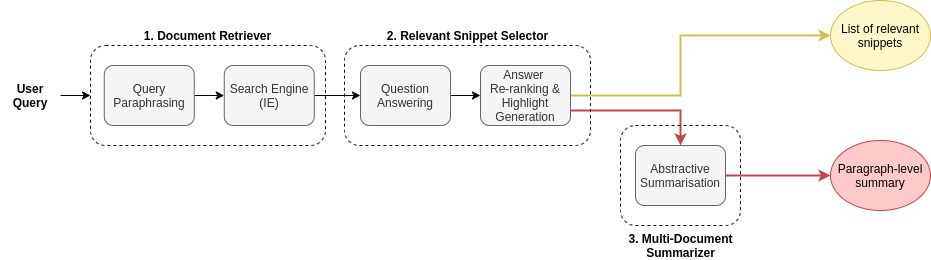
In this section, we will elaborate on the building blocks of each module in our system.
 
1) Document Retriever
+ **Query Paraphrasing**: It converts a long/complicated query from a user to several shorter and simpler questions for search;
+ **Search Engine**: We use Anserini with Lucene to retrieve publications from the candidate pool with high coverage. 
 
2) Relevant Snippet Selector: 
+ **Question Answering(QA)**: This sub-module looks for and integrates evidence from one or multiple paragraphs. We leverage an ensemble of two neural-based QA models which are pre-trained on SQuAD style QA datasets. Here we consider the QA module as a supporting fact selector to provide relevant snippets from the retrieved documents.
+ **Answer Re-ranking & Highlight Generation**:  We rerank the retrieved result by a word matching score based on part-of-speech tagging as well as the QA system confidence score. We also highlight the answer span in order to enable easier reading of the QA results.

3) Multi-document Summarizer:
+ **Abstractive Summarization**: Another output of our system is an abstractive summary that synthesizes the answer from multiple retrieved snippets. This step aims to generate short pieces of fluent summaries based on the top relevant results. Using the neural-based summarizer, we generate summaries to improve the legibility of the results and help the user to have an overview of the relevant snippets in a short time.

# 1. Document retrieval
## 1.1 Query Paraphrasing

The objective of this sub-module is to break down a user’s query and rephrase complex query sentences into several shorter and simpler questions that convey the same meaning.  In this way,  the search engine and the question answering modules will be able to find more relevant and less redundant results. 

Now we convert the task 10 into several questions to answer:

* What has been published about information sharing and inter-sectoral collaboration? 
* What has been published about data standards and nomenclature? 
* What has been published about governmental public health? 
* What do we know about risk communication? 
* What has been published about communicating with high-risk populations? 
* What has been published to clarify community measures? 
* What has been published about equity considerations and problems of inequity?
* what the literature reports about the methods for coordinating data-gathering with standardized nomenclature?
* what the literature reports about sharing response information among planners, providers, and others?
* what the literature reports about understanding and mitigating barriers to information-sharing?
* what the literature reports about how to recruit, support, and coordinate local (non-Federal) expertise and capacity relevant to public health emergency response (public, private, commercial and non-profit, including academic)?
* what the literature reports about integration of federal/state/local public health surveillance systems?
* what the literature reports about value of investments in baseline public health response infrastructure preparedness?
* what the literature reports about modes of communicating with target high-risk populations (elderly, health care workers)?
* what the literature reports about risk communication and guidelines that are easy to understand and follow (include targeting at risk populations’ families too)?
* what the literature reports about communication that indicates potential risk of disease to all population groups?
* what the literature reports about misunderstanding around containment and mitigation?
* what the literature reports about action plan to mitigate gaps and problems of inequity in the Nation’s public health capability, capacity, and funding to ensure all citizens in need are supported and can access information, surveillance, and treatment?
* what the literature reports about measures to reach marginalized and disadvantaged populations?
* what the literature reports about data systems and research priorities and agendas incorporate attention to the needs and circumstances of disadvantaged populations and underrepresented minorities?
* what the literature reports about mitigating threats to incarcerated people from COVID-19, assuring access to information, prevention, diagnosis, and treatment?
* what the literature reports about understanding coverage policies (barriers and opportunities) related to testing, treatment, and care

## 1.2 Search Engine

We use [Anserini](https://github.com/castorini/anserini) to create the search engine to retrieve a preliminary candidate set of documents. Anserini is an information retrieval module wrapped around the open source search engine **Lucene**. Although Lucene has been used widely to build industry search engine applications, its complex indexing and lack of documentation for ad hoc experimentation and testing on standard test sets, has made it less popular in the information retrieval community. Anserini uses the Lucene indexing to create an easy-to-understand module. Standard ranking algorithms(e.g. bag of words, BM25) have been implemented in the module, which enables us to use Lucene for our application. Thanks to Jimmy Lin, we make this platform based on his [notebook](https://github.com/castorini/anserini-notebooks/blob/master/pyserini_covid19_paragraph.ipynb). Since the disk is not large enough for saving the whole dataset with index and other models, we use his API to get the information retrieval results.

### 1.2.1 install Python dependencies and pre-built index

Following the lucene+answerini information retrieval as described in: https://github.com/castorini/anserini/blob/master/docs/experiments-covid.md

Setting up JAVA sdk 11 first:

In [ ]:
!curl -O https://download.java.net/java/GA/jdk11/9/GPL/openjdk-11.0.2_linux-x64_bin.tar.gz

!mv openjdk-11.0.2_linux-x64_bin.tar.gz /usr/lib/jvm/; cd /usr/lib/jvm/; tar -zxvf openjdk-11.0.2_linux-x64_bin.tar.gz
!update-alternatives --install /usr/bin/java java /usr/lib/jvm/jdk-11.0.2/bin/java 1
!update-alternatives --set java /usr/lib/jvm/jdk-11.0.2/bin/java

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/jdk-11.0.2"

Getting the pyserini library, which is anserini wrapped with python:

In [ ]:
!pip install pyserini==0.8.1.0
from pyserini.search import pysearch

We can build the lucene index of the COVID-19 dataset from scratch, or get one of the pre-built indexes. Using the paragraph indexing which indexes each paragraph of an article (already uploaded the index as a dataset to use), can be downloaded from: https://www.dropbox.com/s/ivk87journyajw3/lucene-index-covid-paragraph-2020-04-10.tar.gz

In [ ]:
COVID_INDEX = '../input/luceneindexcovidparagraph20200410/lucene-index-covid-paragraph-2020-04-10'

The indexing is done based on each paragraph merged with the title and abstract. Given an article with id *doc_id*, the index will be as follows:
* *doc_id* : title + abstract
* *doc_id.00001* : title + abstract + 1st paragraph
* *docid.00002*: title + abstract + 2nd paragraph
* *docid.00003*: title + abstract + 3rd paragraph

### 1.2.2 example for using Anserini
Here we type query 'range of incubation periods for COVID-19' in the search engine and it will return the top10 revelant items Anserini gets in the dataset.

In [ ]:
searcher = pysearch.SimpleSearcher(COVID_INDEX)

Let's write some code to print the results, which are top 10 articles matching a given query, along with the best matched paragraph. We are printing some of the fields corresponding to each article, a complete list of fields can be found [here](https://github.com/castorini/anserini/blob/master/src/main/java/io/anserini/index/generator/CovidGenerator.java#L46).

In [ ]:
def get_articles(query):
    hits = searcher.search(query)
    #print(len(hits))
    # Prints the first 10 hits
    return hits

In [ ]:
query = 'range of incubation periods for COVID-19'
hits = get_articles(query)
for i in range(0, 10):
    #print some relevant fields
    print(f'{i+1} {hits[i].docid} {hits[i].score} {hits[i].lucene_document.get("title")} {hits[i].lucene_document.get("doi")}')

We can see some repititions in the results above. This can either be due to multiple paragraphs in the same article being matched with the query, or one article appearing more than once in the CORD-19 dataset, due to different sources. Let's now try printing out the actual paragraph that is being matched with each of the returned hits. First we print out contents of the indexing of the first hit for example:

In [ ]:
hits[0].contents.split('\n')

The first two are title and abstract, and the last element is the matched paragraph. We can see that the paragraph matched is actually quite good at answering the query. The next step would be to get an answer in a concised form by passing the matched paragraphs to a QA model.

We now make another function to get the best matched paragraphs results from the dataset to our given query. If the article in concern does not have full text available then only the abstract is indexed. Since we know the doi field is unique to each article, we check if the article has already appeared before in the list returned. To avoid repetitions, we only include the 'abstract' and the 'body_text' fields form the dataset if the article is new and not a repeated article from before. The function is shown below:

In [ ]:
import json
def get_para_results(query):
    hits = searcher.search(query,10) 
    print(len(hits))
    temp = {} # to store the doi of the articles being returned so we know if the article is repeated
    i = 0
    output = []
    while i<len(hits) and i<10:
        outJson = {}
        outJson['rank'] = i+1
        # check if the current article has a paragraph returned or not ('has_full_text' in the dataset)
        if '.' in hits[i].docid:
            doc_id = hits[i].docid.split('.')[0]
            para_id = hits[i].docid.split('.')[1]
            doi = hits[i].lucene_document.get('doi')
            paragraph = {}
            paragraph['score'] = hits[i].score
            paragraph['text'] = hits[i].contents.split('\n')[-1] # get the last element, since the contents are sorted as [title, abstract, paragraph]
            paragraph['id'] = para_id
            # check if the doi (same article) has not appeared before in the list
            if doi not in temp:
                outJson['abstract'] = hits[i].lucene_document.get('abstract') # include abstract if new article
                article_data = json.loads(searcher.doc(doc_id).lucene_document().get('raw')) # get all the relevant data from the dataset 
                if 'body_text' in article_data:
                    outJson['body_text'] = article_data['body_text'] # include 'body_text' in case needed later
                temp[doi] = i
            outJson['paragraphs'] = []
            outJson['paragraphs'].append(paragraph)
        else:
            # no paragraph present, which means article does not have full text available
            outJson['abstract'] = hits[i].lucene_document.get('abstract')
            outJson['score'] = hits[i].score
        outJson['title'] = hits[i].lucene_document.get('title')
        outJson['sha'] = hits[i].lucene_document.get('sha')
        outJson['doi'] = hits[i].lucene_document.get('doi')
        output.append(outJson)
        i+=1
    return output

We can try running the function for the previous query, and check if the results are what we want.

In [ ]:
query = 'range of incubation periods for COVID-19'
i = 1
for item in get_para_results(query):
    if i>10:
        break
    print(item)
    i+=1

In this project, for sake of efficiency, ***we build an API for the Search Engine module to integrate it with the Question Answering module into this system***.

In [ ]:
def information_retrieval(file_name, topk = 10):

    with open(file_name) as f:
        json_file = json.load(f)
    subtasks = json_file["sub_task"]
    
    all_results = []
    data_for_qa = []
    for item in subtasks:
        questions = item["questions"]
        for query in questions:
            result_item = {"question" : query}
            retri_result = get_para_results(query)
            result_item["data"] = retri_result

            qa_item = {"question": query}
            context = []
            titles = []
            doi = []
            count = 1
            for item in retri_result:
                if count>topk:
                    break
                if 'abstract' in item and len(item['abstract']) > 0:
                    context.append(item['abstract'])
                    doi.append(item["doi"])
                    titles.append(item["title"])
                    count+=1
                if 'paragraphs' in item:
                    context.append(item['paragraphs'][0]['text'])   
                    doi.append(item["doi"])
                    titles.append(item["title"])
                    count+=1

            qa_item["data"] = {"answer": "", "context": context, "doi": doi, "titles": titles}

            all_results.append(result_item)
            data_for_qa.append(qa_item)

    return data_for_qa

def parse_ir_results(query, retri_result, topk = 10):
    all_results = []
    data_for_qa = []
    qa_item = {"question": query}
    result_item = {"question" : query}
    result_item["data"] = retri_result
    context = []
    titles = []
    doi = []
    count = 1
    for item in retri_result:
        if count>topk:
            break
        if 'abstract' in item and len(item['abstract']) > 0:
            context.append(item['abstract'])
            doi.append(item["doi"])
            titles.append(item["title"])
            count+=1
        if 'paragraphs' in item:
            context.append(item['paragraphs'][0]['text'])   
            doi.append(item["doi"])
            titles.append(item["title"])
            count+=1
    qa_item["data"] = {"answer": "", "context": context, "doi": doi, "titles": titles}

    all_results.append(result_item)
    data_for_qa.append(qa_item)    

    return all_results, data_for_qa

    
def information_retrieval_query(query):

    retri_result = get_para_results(query)
    all_results, data_for_qa = parse_ir_results(query, retri_result ,topk = 20)
    
    return all_results, data_for_qa

# 2. Relevant Snippet Selector
## 2.1 Question Answering

For the question answering (QA) module, we have leveraged the BioBERT QA model which is finetuned on the SQuAD dataset and [our generalized QA model](http://https://github.com/yana-xuyan/caireCovid) for MRQA@EMNLP 2019 Shared Task[1]. Instead of fine-tuning the QA models on COVID-19 related datasets, we focus more on maintaining the generalization ability of our system so it can be easily applied to other similar tasks. For the MRQA model, we utilized six datasets, which vary from each other in terms of data source, context lengths, whether multi-hop reasoning is needed, strategies for data augmentation to reduce overfitting to the training data in order to enable generalization to out-of-domain data. Multi-task learning over six datasets is used to fine-tune large pre-trained language model XLNet[2] and it helped achieve promising results. To make the answers more readable, instead of providing small spans of answers, we provide the whole sentences and the surrounding context.  

To better evaluate the question answering results, we leverage the prediction probability of the QA models as the confidence score. The final answers of our system are re-ranked using this score as one of the factors, which will be talked about later in Section 2.2.
 

[1]Su, Dan, et al. "Generalizing Question Answering System with Pre-trained Language Model Fine-tuning." Proceedings of the 2nd Workshop on Machine Reading for Question Answering. 2019.
[2]Yang, Zhilin, et al. "Xlnet: Generalized autoregressive pretraining for language understanding." Advances in neural information processing systems. 2019.

In [ ]:
### 3.1 install the prerequisite
import os
import sys
import json

!pip uninstall tensorflow -y
!pip uninstall tensorflow-gpu -y
!pip install tensorflow==1.13.1
!pip install caireCovid==0.1.8

To accelerate our QA system, instead of running corresponding process in notebook, we leverage an API to make better use of the local GPUs. We also make our QA system public to the community by making python package for downloading with the following command:
> pip install caireCovid

For anyone who may be interested in the implementation details, lease refer to our [Github repository](https://github.com/yana-xuyan/caireCovid). Some examples and other useful resources are also available there.

In [ ]:
import tensorflow as tf
import caireCovid
from caireCovid import QaModule
from caireCovid.qa_utils import stop_words
import math

In [ ]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

In [ ]:
### 3.2 Check all version
print(tf.__version__)

In [ ]:
# QA System
class QA_System():
    def _init_(self):
        # Load the QA models. Please refer to [Github](https://github.com/yana-xuyan/caireCovid) for details.
        self.model = QaModule(['mrqa', 'biobert'], ["/kaggle/input/pretrained-qa-models/mrqa/1564469515", "/kaggle/input/pretrained-qa-models/biobert/1585470591"], \
                              "/kaggle/input/xlnetlargecased/xlnet_cased_L-24_H-1024_A-16/spiece.model", "/kaggle/input/pretrained-qa-models/bert_config.json", \
                              "/kaggle/input/bert-base-cased/vocab.txt")
    def getAnswer(self, query):
        _, data_for_qa = information_retrieval_query(query)
        answers =  self.model.getAnswers(data_for_qa)
        return answers
    def getAnswers(self, filename):
        _, data_for_qa = information_retrieval(query)
        answers = self.model.getAnswers(data_for_qa)
        return answers
    def makeFormatAnswers(self, answers):
        format_answers = []
        for i in range(len(answers[0]['data']['answer'])):
                format_answer = {}
                format_answer['question'] = answers[0]['question']
                format_answer['answer'] = answers[0]['data']['answer'][i]
                format_answer['context'] = answers[0]['data']['context'][i]
                format_answer['doi'] = answers[0]['data']['doi'][i]
                format_answer['title'] = answers[0]['data']['title'][i]
                format_answer["confidence"] = answers[0]['data']['confidence'][i]
                format_answer["raw"] = answers[0]['data']['raw'][i]
                format_answers.append(format_answer)
        return format_answers

def get_QA_answer_api(query):
    url = "http://eez114.ece.ust.hk:5000/query_qa"
    payload = "{\n\t\"text\": \""+query+"\"\n}"
    headers = {
        'Content-Type': "application/json",
        'cache-control': "no-cache",
        'Postman-Token': "696fa512-5fed-45ca-bbe7-b7a1b4d19fe4"
    }
    response = requests.request("POST", url, data=payload, headers=headers)
    response = response.json()
    return response

## 2.2 Highlights Generation

In this part, we introduce the word matching highlight strategy. There are two main components in this part: (1) word matching score calculate. (2) rerank and display. The input is the Question Answering result and for the output we display the most relevant paragraph with the highlighted answer.
+ **POS-tag based scoring:** 
We calculate a similarity score between a QA result and a given query based on keyword matching. To obtain this score, we first select important keywords based on POS-tagging - we consider words with {NN(noun), VB (verb), JJ (adjective)} POS-tags to be important keywords. Based on the set of filtered keywords, we count the word-match between QA-result keywords and query keywords. Higher the count is, more similar the QA-result and the query are. To penalize the matching scores of short retrieved paragraphs, we normalize them with sigmoid value computed from paragraph length. Moreover, we reward the paragraphs with more diverse keywords from query, which is the major factor of matching scores.

+ **rerank and display:**
The re-ranking score is based on both the word matching score above and the confidence score from the QA system. The QA results are again ranked and displayed. 

In [ ]:
import argparse
import sys
import pandas as pd
import csv
import requests
from nltk import word_tokenize, pos_tag
from nltk.tokenize import sent_tokenize # use sentence tokenize
from IPython.core.display import display, HTML

In [ ]:
from nltk import word_tokenize, pos_tag, sent_tokenize
from caireCovid.qa_utils import stop_words
stop_words.append('including')

def rankAnswers(answers):
    for item in answers:
        query = item["question"]
        context = item['context']
        # make new query with only n. and adj.
        tokens = word_tokenize(query.lower())
        tokens = [word for word in tokens if word not in stop_words]
        tagged = pos_tag(tokens)
        query_token = [tag[0] for tag in tagged if 'NN' in tag[1] or 'JJ' in tag[1] or 'VB' in tag[1]]

        text = context.lower()
        count = 0
        text_words = word_tokenize(text)
        for word in text_words:
            if word in query_token:
                count += 1
            
        match_number = 0
        for word in query_token:
            if word == 'covid-19':
                continue
            if word in text_words:
                match_number += 1
        matching_score = count / (1 + math.exp(-len(text_words)+50))/ 5 + match_number*10
        item['matching_score'] = matching_score
        item['rerank_score'] = matching_score + 0.5 * item['confidence']
    
    # sort QA results
    answers.sort(key=lambda k: k["rerank_score"], reverse=True)
#     print([item['rerank_score'] for item in answers])
    return answers

def highlight_qaresult(qaresult):
    if qaresult == []:
        print('API broken')
        return 1
    ## tokenize query
    query = qaresult[0]['question']
    query_tokens = word_tokenize(query.lower())
    query_tokens = [word for word in query_tokens if word not in stop_words]
    tagged = pos_tag(query_tokens)
    query_tokens = [tag[0] for tag in tagged if 'NN' in tag[1] or 'JJ' in tag[1] or 'VB' in tag[1]]

    ## highlihgt answer
    for i in range(len(qaresult)):
        context_1 = "<style type='text/css'>mark { background-color:yellow; color:black; } </style>"
        golden = qaresult[i]['answer']
        context = qaresult[i]['context']
        context_sents = sent_tokenize(context)
        golden_sents = sent_tokenize(golden)
        for sent in context_sents:
            if sent not in golden:
                context_1 += sent
            else:
                context_1 += "<mark>"
                for word in sent.split():
                    word_tokens = word_tokenize(word)
                    if len(word_tokens) > 1:
                        for j in word_tokens:
                            if j.lower() in query_tokens:
                                context_1 = context_1 + "<b>" + j + "</b>"
                            else:
                                context_1 = context_1 + j
                        context_1 = context_1 + " "
                    else:
                        for j in word_tokens:
                            if j.lower() in query_tokens:
                                context_1 = context_1 + "<b>" + j + " </b>"
                            else:
                                context_1 = context_1 + j + " "
                context_1 += " </mark>"
        qaresult[i]['context'] = context_1
    return qaresult

def display_QA(result):
    result = highlight_qaresult(result)
    pdata = []
    count = 0
    for i in range(len(result)):
        count += 1
        line = []
        context_1 = "<div> "
        context = result[i]['context']
        context_1 = context_1 + context
        context_1 += " </div>"
        line.append(context_1)
        context_2 = '<a href= "https://doi.org/'
        context_2 += result[i]['doi']
        context_2 += ' target="_blank">'
        context_2 += result[i]['title']
        context_2 += '</a>'
        line.append(context_2)
        pdata.append(line)
        if count > 5:
            break
    df = pd.DataFrame(pdata, columns = ['QA results', 'title'])
    df = df.style.set_properties(**{'text-align': 'left','mark-color': 'red'})
    display(df)

# 3. Abstractive Summerization

Automatic text summarization is a common problem in machine learning and natural language processing (NLP). Basically there are two main types of how to summarize text in NLP:
* **Extraction-based summarization**, which involves pulling key phrases from the source document and combining them to make a summary, and;
* **Abstraction-based summarization**, which creates new phrases and sentences that relay the most useful information from the original text — just like humans do. 
In general, the abstractive method is a much harder task but performs better than an extractive method.

In our project, considering the requirements that people may still want to further read each paragraph containing the predicted QA answer spans, we summarize the top-k  (top-3) paragraphs that QA module passes, to generate a **paragraph-level abstractive summary**. 

Our model is based on two different abstractive summarization models: [Unilm](https://github.com/microsoft/unilm/tree/master/s2s-ft) and [BART](https://github.com/pytorch/fairseq/tree/master/examples/bart), both of which have obtained SOTA results on the summarization tasks ([CNN/DM datasets](https://cs.nyu.edu/~kcho/DMQA/), and [XSUM](https://github.com/EdinburghNLP/XSum/tree/master/XSum-Dataset) data). UniLM model is a unified pre-trained model for language understanding and generation. BART is a sequence-to-sequence model trained with denoising as a pre-training objective for language generation, translation, and comprehension.

We fine-tuned the UniLM model using [SumOnGraph](https://github.com/coshiang/SumOnGraph) biology dataset which includes literature for 5 types of diseases including Cancer, Cardiovascular Disease, Diabetes, Allergy, and Obesity. Original data is from PubMed which is a free resource supporting the search and retrieval of biomedical and life sciences literature with the aim of improving health–both globally and personally. We used the BART model fine-tuned on CNN/DailMail dataset. 

We generate a summary for each answer-related paragraph from the QA module, then concatenate them directly to form our final **paragraph-level** answer summary.

*(Actually we also implement **article-level summary**, even though in this Kaggle project, for the simplicity and legibility, we only display **the paragraph-level results** of the summarization models. It takes the whole article as input, and generate a summary for each sections (eg. Introductions section, Methodologies section)  of the articles, and then concatenate them together as a more fine-grained **article-level summary**, as complementary to the abstracts. You can refer to this [github repository](https://github.com/Iamfinethanksu/covidSumm) for more details.)*

If anyone is interested in our article-level results, please utilize ```summary = get_article_summary(query, abstractive_summary_model)``` to obtain the results from our system. 

* install the prerequisite packages
(The covidSumm packages are from [here](https://github.com/Iamfinethanksu/covidSumm).

In [ ]:
!pip install easydict
!pip install covidSumm==0.1.4
!pip install fairseq

In [ ]:
import covidSumm
import requests
import json
import os
import argparse

In [ ]:
from covidSumm.abstractive_utils import get_ir_result, result_to_json, get_qa_result
from covidSumm.abstractive_model import abstractive_summary_model
from covidSumm.abstractive_config import set_config
from covidSumm.abstractive_bart_model import *

In [ ]:
def get_summary_list(article_list, abstractive_model):
    summary_list = []
    for i in range(len(article_list)):
        article = article_list[i]
        summary_results = abstractive_model.generate_summary(article)
        result = ""
        for item in summary_results:
            result += item.replace('\n', ' ')
        summary_list.append(result)
    return summary_list

def get_answer_summary(query, abstractive_model):
    paragraphs_list = get_qa_result(query, topk = 3)
    answer_summary_list = abstractive_model.generate_summary(paragraphs_list)
    answer_summary = ""
    for item in answer_summary_list:
        answer_summary += item.replace('\n', ' ')
    answer_summary_json = {}
    answer_summary_json['summary'] = answer_summary
    answer_summary_json['question'] = query
    return answer_summary_json

def get_article_summary(query, abstractive_summary_model):
    article_list, meta_info_list = get_ir_result(query, topk = 10)  
    summary_list = get_summary_list(article_list, abstractive_summary_model)
    summary_list_json = []
    
    for i in range(len(summary_list)):
        json_summary = {}
        json_summary = result_to_json(meta_info_list[i], summary_list[i])
        summary_list_json.append(json_summary)

    return summary_list_json

def get_bart_answer_summary_from_qa(query, qa_result, bart_model):
    # we select top3
    paragraphs_list = []
    topk = 3

    for i in range(topk):
        if 'context' in qa_result[i].keys():
            one_line = {}
            one_line['src'] = qa_result[i]['context']
            one_line['tgt'] = ""
            paragraphs_list.append(one_line)
    
    answer_summary_list = bart_model.bart_generate_summary(paragraphs_list)
    answer_summary_result = ""
    for item in answer_summary_list:
        answer_summary_result += item.replace('\n', ' ')
    
    answer_summary_json = {}
    answer_summary_json['summary'] = answer_summary_result
    answer_summary_json['question'] = query
    return answer_summary_json

* Now we initiate our **Summerization model UniLM**.

In [ ]:
args = set_config()
args['model_path'] = '/kaggle/input/carieabssummmodel/'
summary_model_1 = abstractive_summary_model(config = args)

* We initiate our **Summerization model BART**.

In [ ]:
model_path = "/kaggle/input/bartsumm/bart.large.cnn"
summary_model_2 = Bart_model(model_path)

In [ ]:
from IPython.core.display import display, HTML
import pandas as pd

def display_summary(ans_summary_json, model_type):
    question = ans_summary_json['question']
    text = ans_summary_json['summary']
    question_HTML = '<div style="font-family: Times New Roman; font-size: 28px; padding-bottom:28px"><b>Query</b>: '+question+'</div>'
    display(HTML(question_HTML))

    execSum_HTML = '<div style="font-family: Times New Roman; font-size: 18px; margin-bottom:1pt"><b>' + model_type + ' Abstractive Summary:</b>: '+text+'</div>'
    display(HTML(execSum_HTML))

def display_article_summary(result, query):
    question_HTML = '<div style="font-family: Times New Roman; font-size: 28px; padding-bottom:28px"><b>Query</b>: '+query+'</div>'
    pdata = []
    abstract = ""
    summary = ""
    for i in range(len(result)):
        if 'abstract' in result[i].keys():
            line = []
            context_2 = '<a href= "https://doi.org/'
            context_2 += result[i]['doi']
            context_2 += ' target="_blank">'
            context_2 += result[i]['title']
            context_2 += '</a>'
            line.append(context_2)
            
            abstract = "<div> " 
            abstract += result[i]['abstract']
            abstract += " </div>"
            line.append(abstract)
            summary = "<div> " + result[i]['summary'] + " </div>"
            line.append(summary)


            pdata.append(line)
    display(HTML(question_HTML))
    df = pd.DataFrame(pdata, columns = ['Title','Abstract','Summary'])
    HTML(df.to_html(render_links=True, escape=False))
#     display(HTML(df.to_html(render_links=True, escape=False)))
    df = df.style.set_properties(**{'text-align': 'left'})
    display(df)


# Let's try now

Write down whatever question you are interested in below. For example:

In [ ]:
query = "How incubation period for COVID-19 varies across age?"

In [ ]:
def run_example(query):
    # Given one query, we retrieve the relevant paragraphs and feed the (paragraph, query) pairs into the QA system 
    qa_result = get_QA_answer_api(query)
    # Answer Reranking
    qa_result = rankAnswers(qa_result)
    
    # Input "summary_model_2" is the BART summarization model.
    # Function "get_bart_answer_summary" is loaded from covidSumm.abstractive_bart_model
    # Given one query, we take top-3 reranked paragraphs from the QA module and summarize them into one paragraph
    answer_summary_2 = get_bart_answer_summary_from_qa(query, qa_result, summary_model_2)
    display_summary(answer_summary_2, 'BART')
    display_QA(qa_result)

### Please try it!

In [ ]:
run_example(query)

# What has been published about information sharing and inter-sectoral collaboration?

In [ ]:
query = "What has been published about information sharing and inter-sectoral collaboration?"
run_example(query)

# What has been published about data standards and nomenclature? 

In [ ]:
query = "What has been published about data standards and nomenclature?"
run_example(query)

# What has been published about governmental public health?

In [ ]:
query = "What has been published about governmental public health?"
run_example(query)

# What do we know about risk communication?

In [ ]:
query = "What do we know about risk communication?"
run_example(query)

# What has been published about communicating with high-risk populations? 

In [ ]:
query = "What has been published about communicating with high-risk populations?"
run_example(query)

# What has been published to clarify community measures? 

In [ ]:
query = "What has been published to clarify community measures?"
run_example(query)

# What has been published about equity considerations and problems of inequity?

In [ ]:
query = "What has been published about equity considerations and problems of inequity?"
run_example(query)

# what the literature reports about the methods for coordinating data-gathering with standardized nomenclature?

In [ ]:
query = "what the literature reports about the methods for coordinating data-gathering with standardized nomenclature?"
run_example(query)

# what the literature reports about sharing response information among planners, providers, and others?


In [ ]:
query = "what the literature reports about sharing response information among planners, providers, and others?"
run_example(query)

# what the literature reports about how to recruit, support, and coordinate local (non-Federal) expertise and capacity relevant to public health emergency response (public, private, commercial and non-profit, including academic)?


In [ ]:
query = "what the literature reports about how to recruit, support, and coordinate local (non-Federal) expertise and capacity relevant to public health emergency response (public, private, commercial and non-profit, including academic)?"
run_example(query)

# what the literature reports about integration of federal/state/local public health surveillance systems?

In [ ]:
query = "what the literature reports about integration of federal/state/local public health surveillance systems?"
run_example(query)

# what the literature reports about value of investments in baseline public health response infrastructure preparedness?

In [ ]:
query = "what the literature reports about value of investments in baseline public health response infrastructure preparedness?"
run_example(query)

# what the literature reports about modes of communicating with target high-risk populations (elderly, health care workers)?


In [ ]:
query = "what the literature reports about modes of communicating with target high-risk populations (elderly, health care workers)?"
run_example(query)

# what the literature reports about risk communication and guidelines that are easy to understand and follow?

In [ ]:
query = "what the literature reports about risk communication and guidelines that are easy to understand and follow?"
run_example(query)

# what the literature reports about communication that indicates potential risk of disease to all population groups?

In [ ]:
query = "what the literature reports about communication that indicates potential risk of disease to all population groups?"
run_example(query)

# what the literature reports about misunderstanding around containment and mitigation?

In [ ]:
query = "what the literature reports about misunderstanding around containment and mitigation?"
run_example(query)

# what the literature reports about data systems and research priorities and agendas incorporate attention to the needs and circumstances of disadvantaged populations and underrepresented minorities?


In [ ]:
query = "what the literature reports about data systems and research priorities and agendas incorporate attention to the needs and circumstances of disadvantaged populations and underrepresented minorities?"
run_example(query)

# what the literature reports about mitigating threats to incarcerated people from COVID-19, assuring access to information, prevention, diagnosis, and treatment?


In [ ]:
query = "what the literature reports about mitigating threats to incarcerated people from COVID-19, assuring access to information, prevention, diagnosis, and treatment?"
run_example(query)

# what the literature reports about understanding coverage policies (barriers and opportunities) related to testing, treatment, and care

In [ ]:
query = "what the literature reports about understanding coverage policies (barriers and opportunities) related to testing, treatment, and care?"
run_example(query)